In [1]:
###############################################
#   02.10.2020, Evgenia Galytska (EG), IUP-UB #
# Analyse CMIP6 historical data with Tigramite# 
###############################################
#Import libraries
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import sklearn
import os
import iris
import time
import xarray as xr
import collections
from scipy import stats
#Import tigramite
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
##################################################################################
##################################################################################
# Download "functions_support" together with this script to correctly read time  #
# info from my .nc file and reproduce time on Tigramite timeseries x-axis        #
from functions_support import toYearFraction                                     #
##################################################################################

from collections import defaultdict #I use it to create my own dictionary for the Section2 of this script

################################################
#      Want my plots to look pretty            #  
import matplotlib.patheffects as path_effects  
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
################################################

plot_save =  True 
detrend_on = True
##########################
# Settings for Tigramite #
##########################
max_timelag = 3
set_alpha = 0.01
pc_alpha = 0.2

# Section 1. Load data and run Tigramite

In [2]:
DIR = os.path.expanduser('/home2/egalytska/DATA/Arctic_midlat_teleconnection/fin/')
PATH_ = os.path.join(DIR, 'CMIP6_historical_actors.nc')
c = iris.load_raw(PATH_)
coord = c[0].coord('date') 
time_array = np.asarray(coord.units.num2date(coord.points))
date_upd  = list ()
for i in range (0, len (time_array)):
    date_upd.append(toYearFraction(time_array[i])) 
date_fin = np.asarray (date_upd)

/home2/egalytska/anaconda3/envs/tiger_Arctic/lib/python3.8/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2341: UserWarning: Failed to create 'model_name' dimension coordinate: The 'model_name' DimCoord points array must be numeric.
Gracefully creating 'model_name' auxiliary coordinate instead.
  warnings.warn(msg.format(name=str(cf_coord_var.cf_name),
/home2/egalytska/anaconda3/envs/tiger_Arctic/lib/python3.8/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2341: UserWarning: Failed to create 'model_name' dimension coordinate: The 'model_name' DimCoord points array must be numeric.
Gracefully creating 'model_name' auxiliary coordinate instead.
  warnings.warn(msg.format(name=str(cf_coord_var.cf_name),
/home2/egalytska/anaconda3/envs/tiger_Arctic/lib/python3.8/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2341: UserWarning: Failed to create 'model_name' dimension coordinate: The 'model_name' DimCoord points

In [3]:
data        =xr.open_dataset(PATH_)
print (data)
model_name  = data.model_name.data
sic         = data.BK_SIC.data
hf          = data.HF.data
pv          = data.PV.data
ao          = data.AO.data
psl_ural    = data.PSL_Ural.data
psl_sib     = data.PSL_Siberia.data
datalist = model_name

<xarray.Dataset>
Dimensions:      (date: 432, model_name: 20)
Coordinates:
  * model_name   (model_name) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
  * date         (date) datetime64[ns] 1979-01-31 1979-02-28 ... 2014-12-31
Data variables:
    TAS          (model_name, date) float64 ...
    BK_SIC       (model_name, date) float64 ...
    HF           (model_name, date) float32 ...
    PV           (model_name, date) float64 ...
    AO           (model_name, date) float32 ...
    NAO          (model_name, date) float32 ...
    PDO          (model_name, date) float32 ...
    QBO          (model_name, date) float64 ...
    THF          (model_name, date) float64 ...
    PSL_Siberia  (model_name, date) float64 ...
    PSL_Ural     (model_name, date) float64 ...


In [4]:
for i in range (0, len (model_name)):
    if detrend_on:
        
        reg = stats.linregress(range(0,len(sic[i,:])), sic[i,:])
        sic[i,:] = sic[i,:] - (reg[1] + (reg[0] * range(0,len(sic[i,:]))))
        
        reg = stats.linregress(range(0,len(hf[i,:])), hf[i,:])
        hf[i,:] = hf[i,:] - (reg[1] + (reg[0] * range(0,len(hf[i,:]))))
        
        reg = stats.linregress(range(0,len(pv[i,:])), pv[i,:])
        pv[i,:] = pv[i,:] - (reg[1] + (reg[0] * range(0,len(pv[i,:]))))

        reg = stats.linregress(range(0,len(ao[i,:])), ao[i,:])
        ao[i,:] = ao[i,:] - (reg[1] + (reg[0] * range(0,len(ao[i,:]))))          
                
        reg = stats.linregress(range(0,len(psl_ural[i,:])), psl_ural[i,:])
        psl_ural[i,:] = psl_ural[i,:] - (reg[1] + (reg[0] * range(0,len(psl_ural[i,:]))))       
        
        reg = stats.linregress(range(0,len(psl_sib[i,:])), psl_sib[i,:])
        psl_sib[i,:] = psl_sib[i,:] - (reg[1] + (reg[0] * range(0,len(psl_sib[i,:]))))

In [5]:
var_names = [ 'PV', 'BK-SIC', 'v-flux','Ural-SLP', 'Sib-SLP', 'AO' ]
data= np.zeros(( len (model_name), len (date_fin),  len (var_names)))
data[:, :, 0] = pv
data[:, :, 1] = sic
data[:, :, 2] = hf
data[:, :, 3] = psl_ural
data[:, :, 4] = psl_sib
data[:, :, 5] = ao

M, T, N = data.shape
print("# Models   Data Length   # of Actors")
print( '   ',  M, '     ' ,T, '           ', N)

# Models   Data Length   # of Actors
    20       432             6


In [6]:
# Mask for DJF
monnum = np.tile(np.arange (1,13,1),int (T/12)) # T -> length of dataset in months 
data_mask = np.zeros(data.shape)
data_DJF= np.where(np.logical_and(monnum > 2, monnum < 12), 1,0)
for n in range (0, N):
    data_mask[:,:, n] = data_DJF

In [7]:
dataframe_list = list ()
for i in range (0, len (model_name)):
    dataframe = pp.DataFrame(data[i, :, :], datatime = date_fin, var_names = var_names, mask = data_mask[i, :, :])
    dataframe_list.append (dataframe)

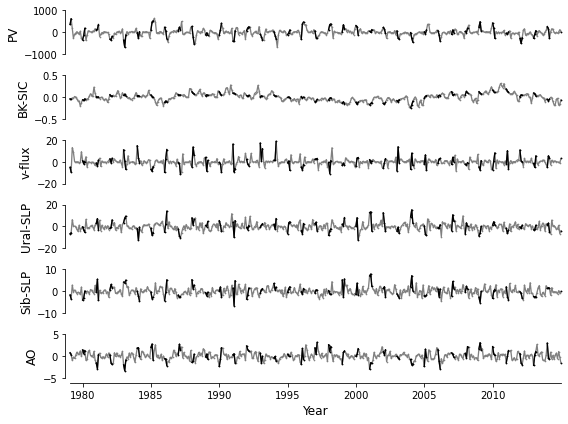

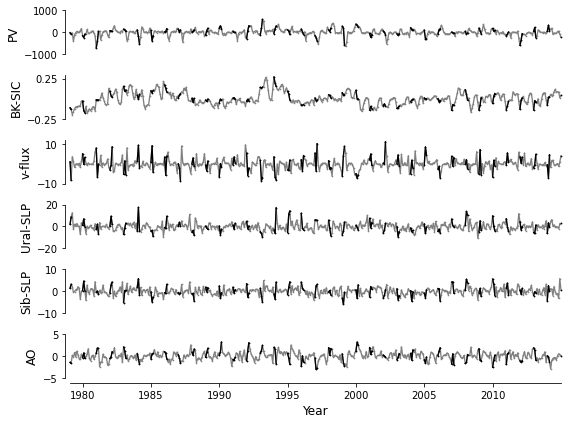

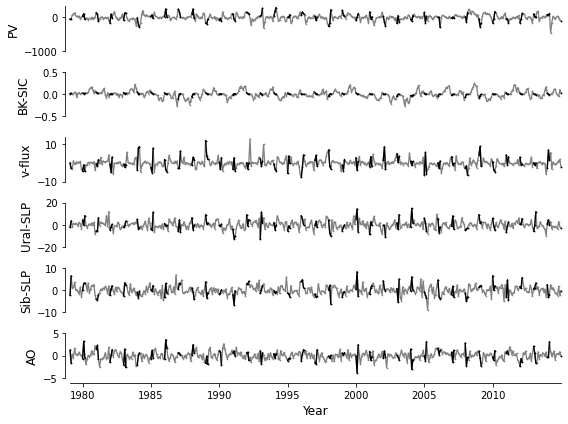

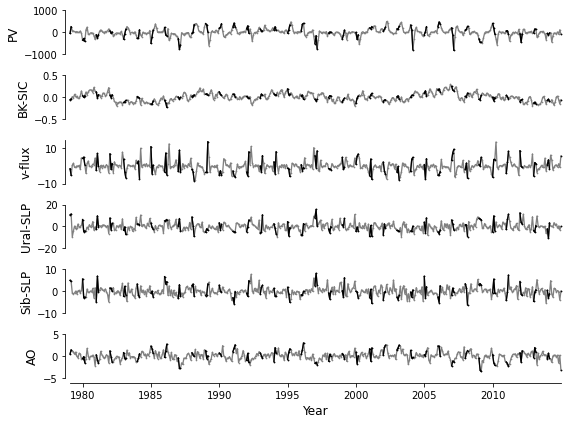

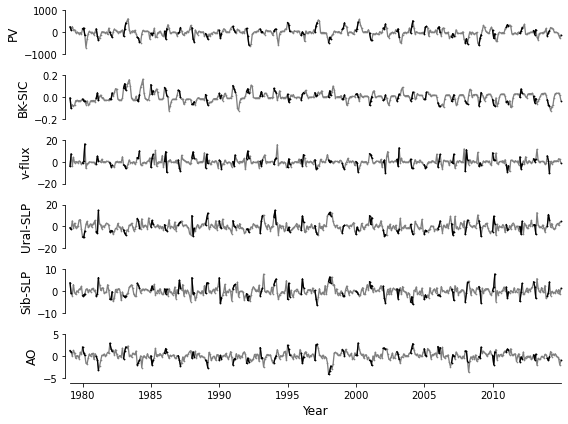

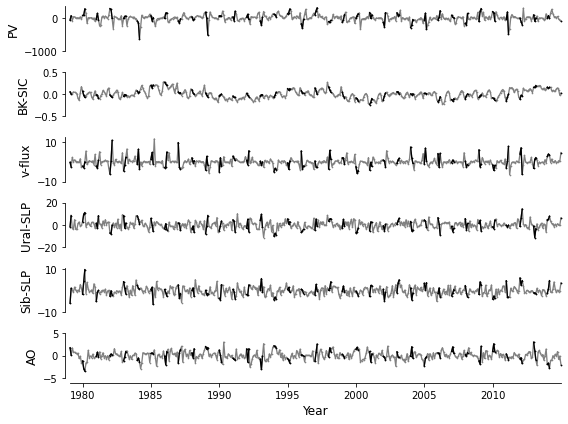

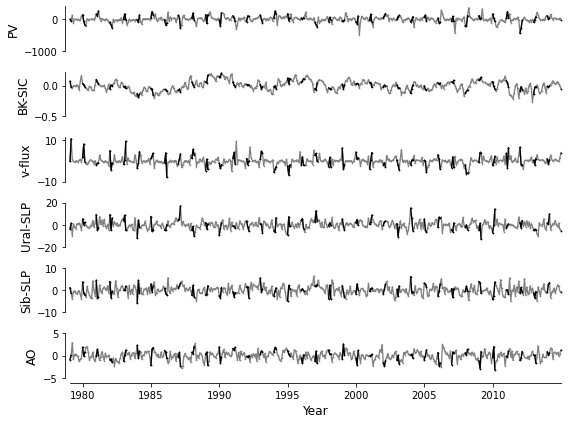

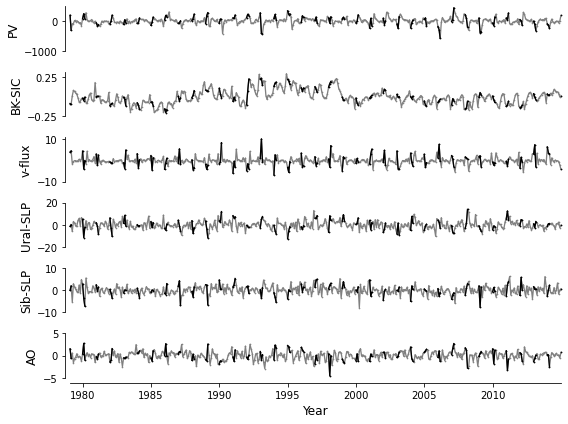

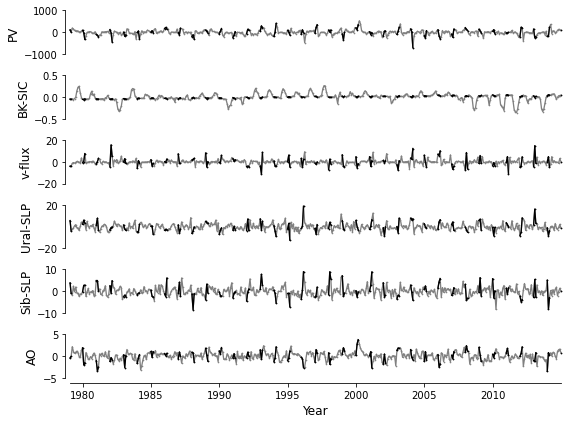

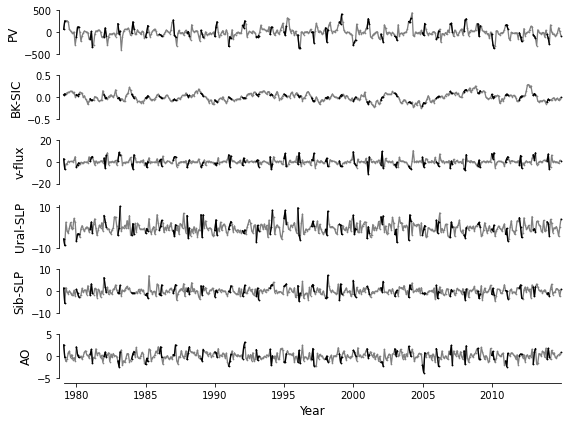

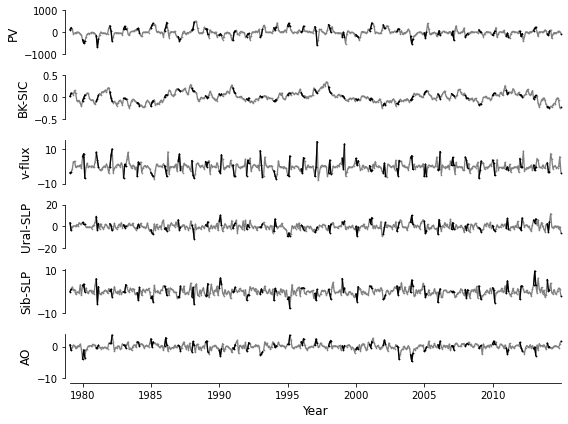

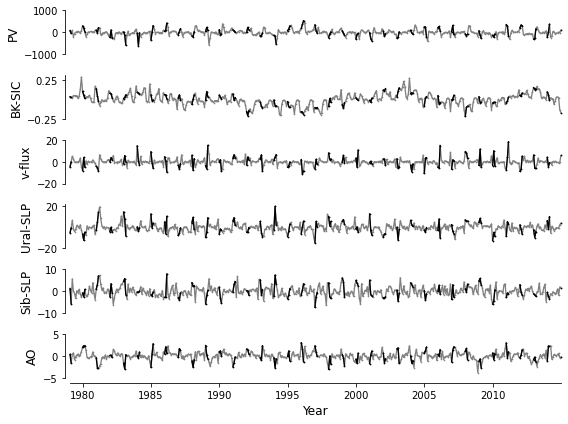

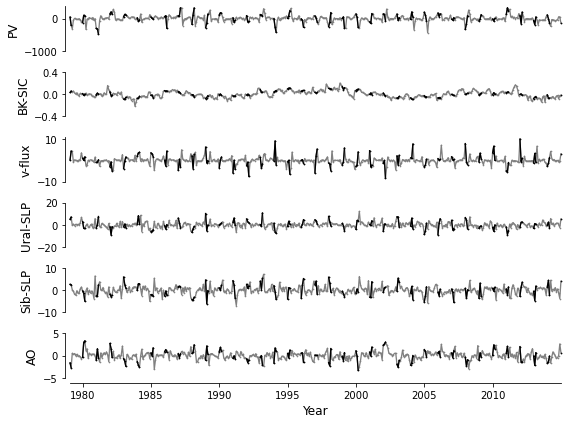

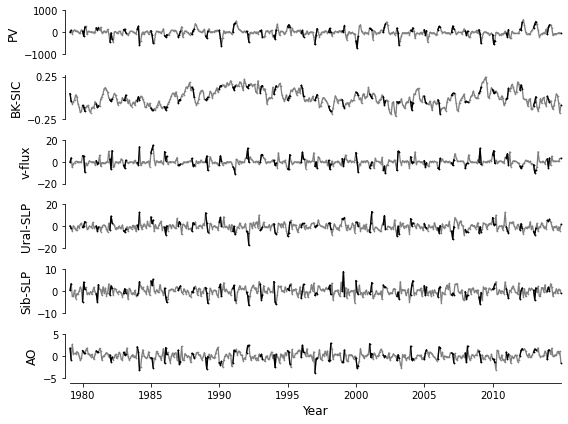

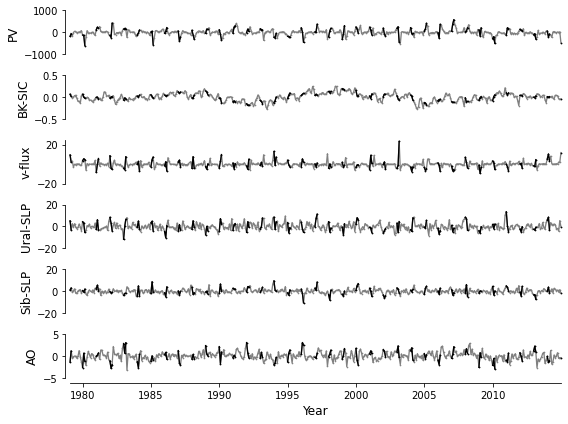

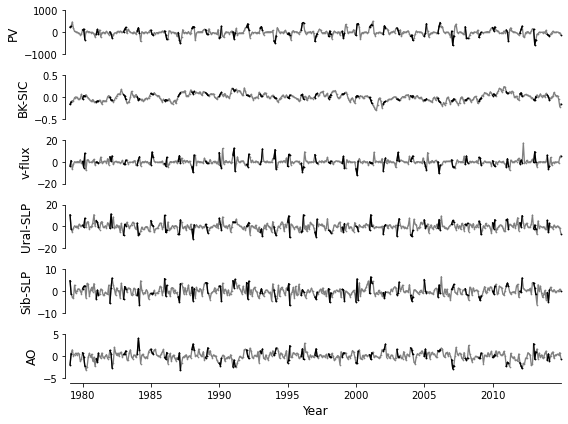

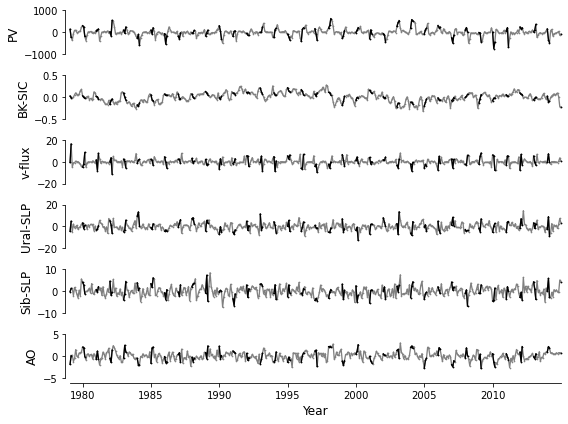

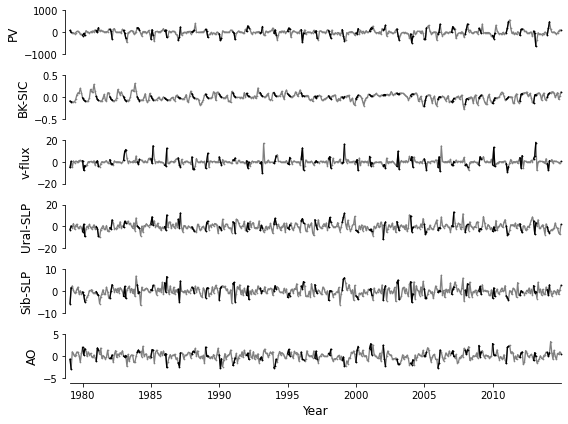

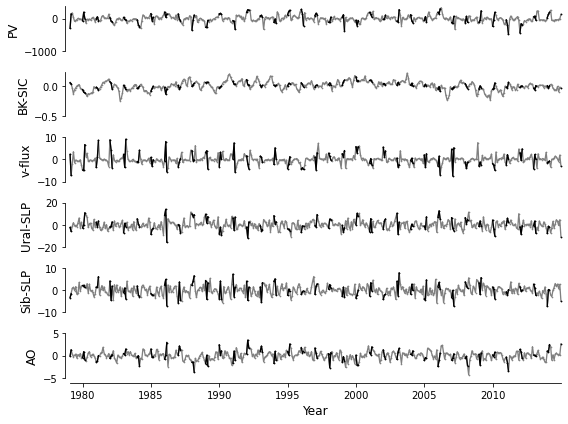

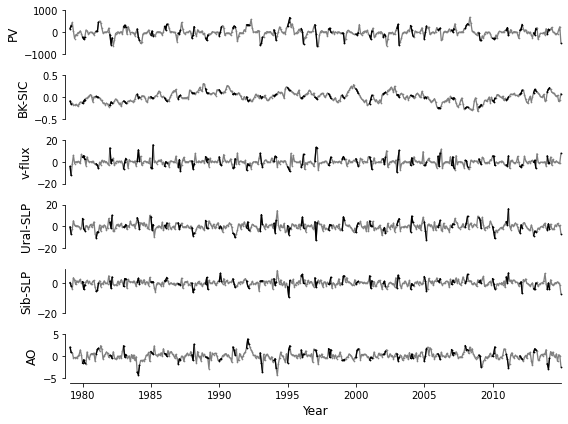

In [8]:

for i in range (0, len (model_name)):
#    if plot_save:
#        plot_name = '/home/egalytska/tigramite/results_plots/Arctic_amplification/cmip6/10models/'+model_name[i]+'1979-2014_timeseries_DJF.png'
    tp.plot_timeseries(dataframe=dataframe_list[i], 
                       figsize = (8,6),
                       time_label = 'Year',
                       data_linewidth = 1.3, 
                       skip_ticks_data_x=1,
                       skip_ticks_data_y=2,
                       label_fontsize=12,
                       use_mask=True, 
                       grey_masked_samples='data',
#                       save_name=plot_name, 
                      )


In [9]:
parcorr = ParCorr(significance='analytic', mask_type='y')
pmci_list = list ()
corr_list = list ()
results_list = list ()
link_matrix_list = list ()
val_matrix_list  = list ()
for i in range (0, len (model_name)):
    pcmci = PCMCI(dataframe=dataframe_list[i], cond_ind_test=parcorr)
    pmci_list.append (pcmci)
    correlations = pcmci.get_lagged_dependencies(tau_min=0, tau_max=max_timelag)
    corr_list.append (correlations)
    results = pcmci.run_pcmci(tau_min=0, tau_max=max_timelag, pc_alpha=pc_alpha)
    results_list.append (results)
    link_matrix = pcmci.return_significant_links(pq_matrix=results['p_matrix'],
                           val_matrix=results['val_matrix'], alpha_level=set_alpha)['link_matrix']
    link_matrix_list.append (link_matrix)
    
    val_matrix_list.append (results['val_matrix'])

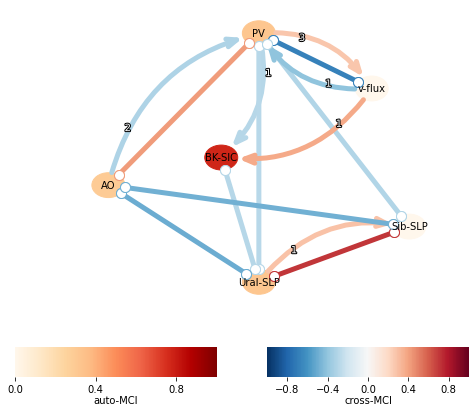

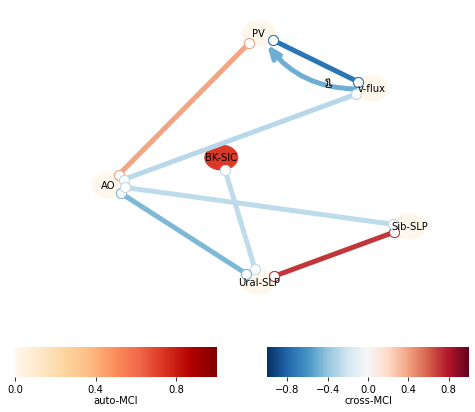

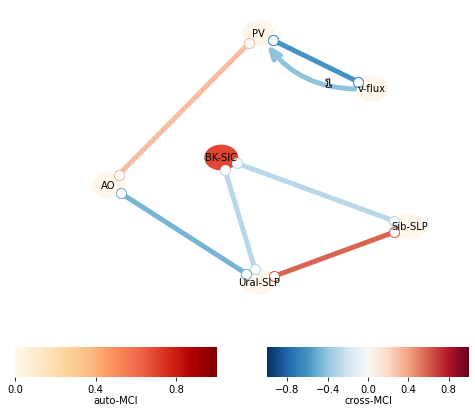

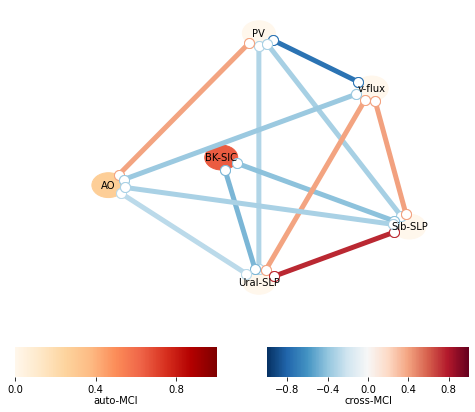

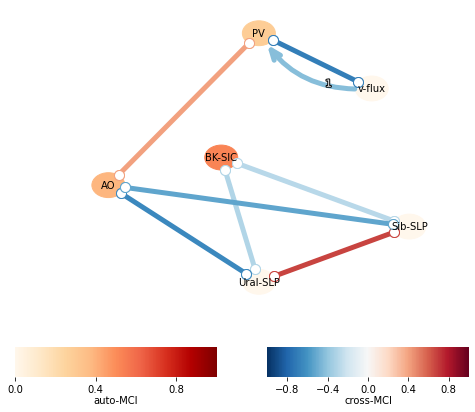

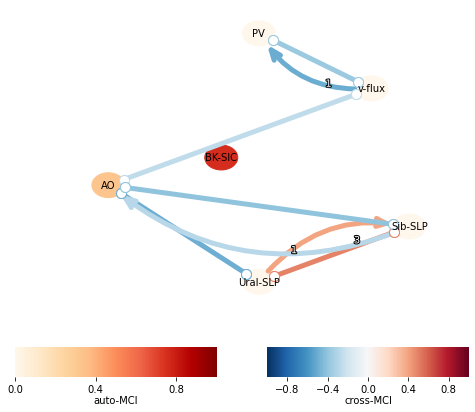

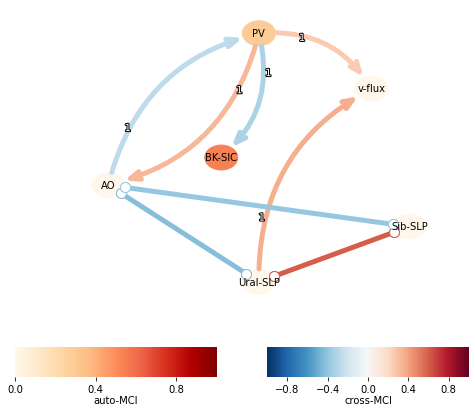

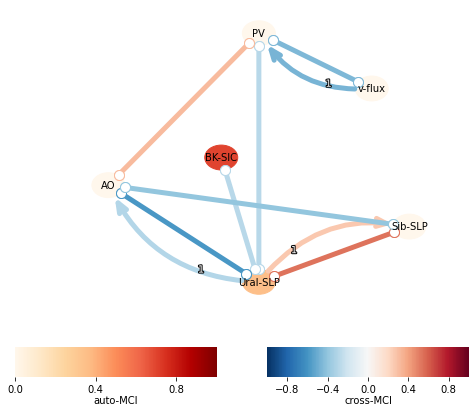

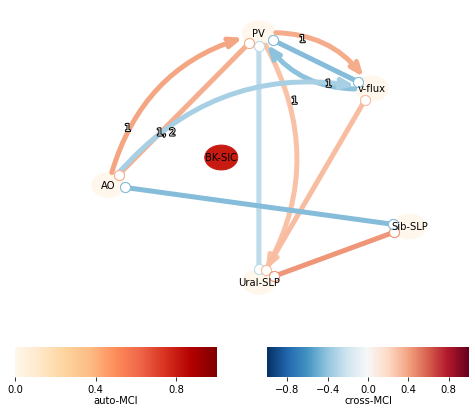

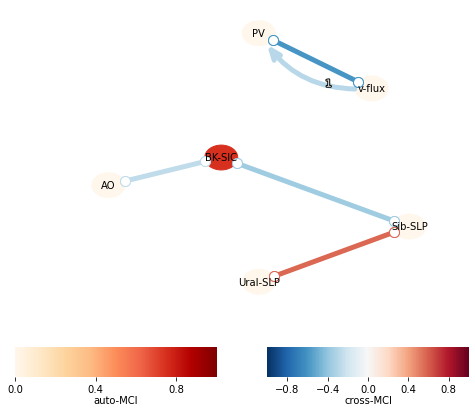

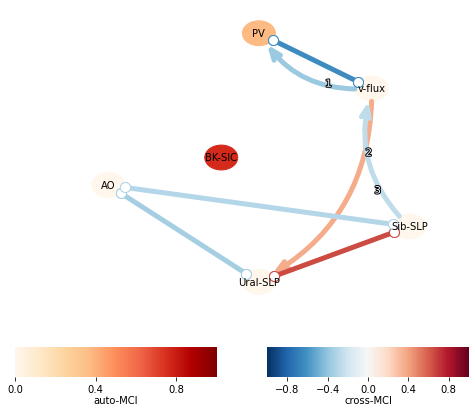

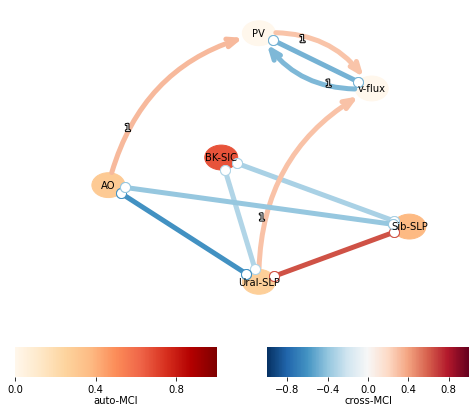

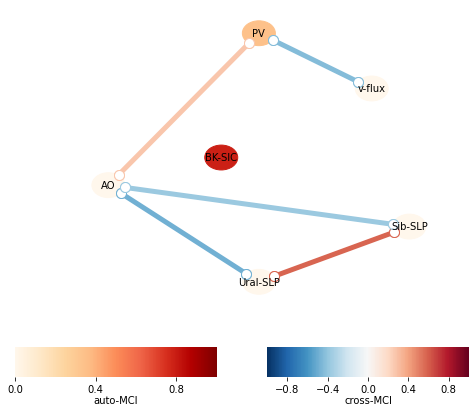

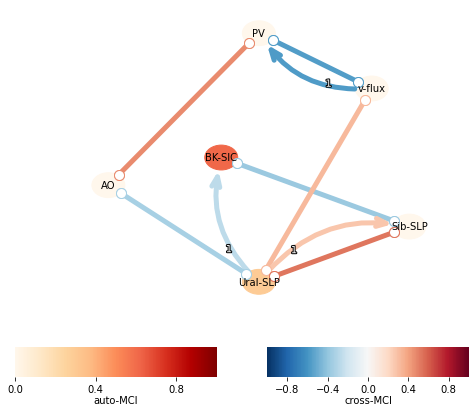

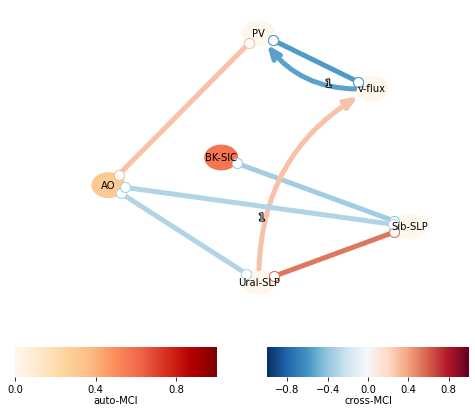

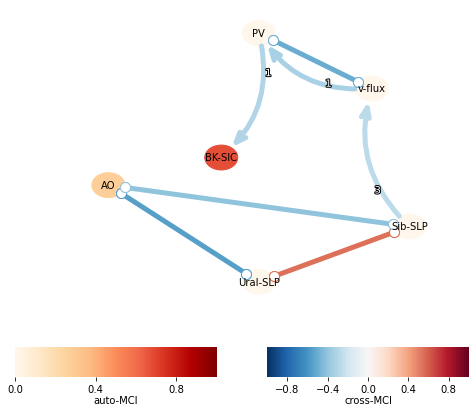

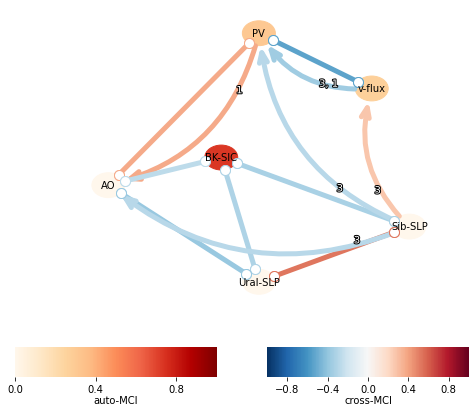

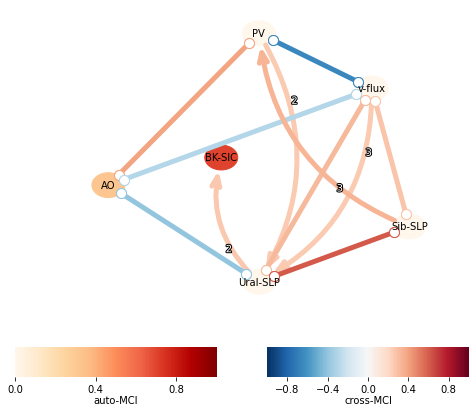

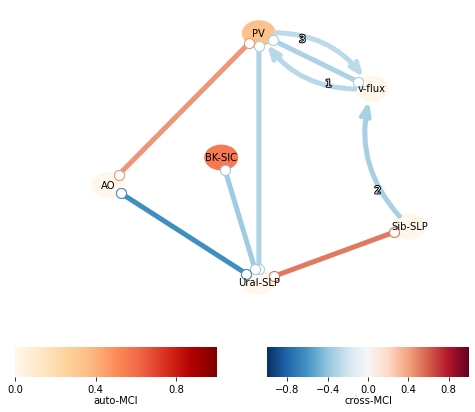

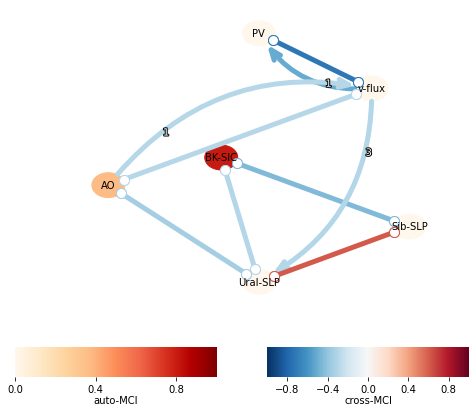

In [10]:
for i in range (0, len (model_name)):
#    if plot_save:
#        plot_name = '/path_to_your_folder/'+model_name[i]+'_1979-2014_graph_DJF.png'  
    tp.plot_graph(
        val_matrix=results_list[i]['val_matrix'],  
        link_matrix=link_matrix_list[i],           
        figsize = (7,7),
        vmin_edges=-1., 
        vmax_edges=1.,             
        #                              PV BK-SIC v-flux  Ural-SLP  Sib-SLP  AO   
        node_pos = {'x': np.array([ 5.0, 4.0,   8.0,    5.0,       9.0 ,  1.0, ]),
                   'y': np.array([ 10.0, 5.5,   8.0,    1.0,       3.0,   4.5,  ])},
        node_size=0.9,              # size of autocorrelation circles
        curved_radius=0.3,          # curvature of the plot  
        network_lower_bound=0.25,   # bound (distance) between plot and colorbar
        show_colorbar=True,
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
#        save_name=plot_name,
        )

# Section 2. Create summary plots

### Part 1. Prepare dictionaries for the 'summary' plots

In [11]:
# EG: Now for each datasource I check link_matrix and collect all 'true' values
# EG: Below I create 2 dictionaries: for correlated and autocorrelated links.
dict_corr = {}
dict_autocorr = {}

for d, datasource in enumerate (datalist): 
    print (d, datasource)
    links_autocorr_list = list ()
    cross_r = list ()
    links_r = list ()
    lags_r = list ()
    # val_matrix has a shape of (N, N, max_timelag +1), so we loop trhrough each value
    for i in range (0, N):
        for j in range (0, N): 
            for lag in range (0, (max_timelag +1)):
                                # First, lets collect all autocorrelation values into dict_autocorr. For that -->
                # check if value in link_matrix is "True"
                if str(link_matrix_list[d][i,j,lag]) == 'True':
                    #and if var_names in the first and second columns are the same (correlation of variable with itself)
                    if var_names[i] == var_names[j]:
                        # then we collect autocorrelation values in "links_autocorr_list": 
                        # actor name --> var_names[i], time lag --> lag, values of cross-correlation for each link --> val_matrix_list[d][i,j,k]                              
                        links_autocorr_list.append ([var_names[i], lag, val_matrix_list[d][i,j,lag]])
                        dict_autocorr[datasource] = links_autocorr_list
                    # now deal with correlated actors
                    else: 
                        
                        #Collect important vals into small lists
                        links_r.append (var_names[i] + '-> '+ var_names[j])
                        lags_r.append (lag)
                        cross_r.append (val_matrix_list[d][i,j,lag])
                        
                        # In the next 11 lines I remove duplicates of links (e.g. PDO--NAO and NAO--PDO)
                        # from my "links_r", "lags_r", and "cross_r" lists.
                        s = list ()
                        skipped = list ()
                        for ind, var in enumerate (cross_r):
                            if var not in s:
                                s.append (var)
                            else:
                                skipped.append (ind)
                        for index in sorted(skipped, reverse=True):
                            del cross_r[index]
                            del links_r[index]
                            del lags_r[index]
                        # And here I just create a list "removed_duplicates" with final data and save to the dictionary "dict_corr"
                        removed_duplicates = list ()
                        for idn in range (0, len (cross_r)):
                            removed_duplicates.append ([links_r[idn], lags_r[idn],cross_r [idn]])
                        dict_corr[datasource] = removed_duplicates

0 ACCESS-CM2
1 ACCESS-ESM1-5
2 CAMS-CSM1-0
3 CanESM5
4 CMCC-CM2-SR5
5 E3SM-1-0
6 E3SM-1-1-ECA
7 E3SM-1-1
8 GISS-E2-1-H
9 INM-CM4-8
10 INM-CM5-0
11 IPSL-CM6A-LR
12 MIROC6
13 MPI-ESM-1-2-HAM
14 MPI-ESM1-2-HR
15 MPI-ESM1-2-LR
16 MRI-ESM2-0
17 NESM3
18 NorCPM1
19 TaiESM1


In [12]:
#######################################################################################################
# Here comes fine tuning of the information for the final plots.                                      #
# If one link has several conenctions (e.g. PV--> v-flux have 1 instantaneous and 1 causal link,      #
# I use "defaultdictionary", so all two links will be shown in 1 column for PV--> v-flux connection)  #
# See e.g. PV--> v-flux link for ACCESS-CM2 or GISS-E2-1-H models in the final "summary" plot.        #
#######################################################################################################
lll = list ()
for datasource in datalist:
    tr = defaultdict(list) 
    for a, b, c in dict_corr[datasource]: 
        tr[a].append ([b,c])
    lll.append (tr)

lll_auto = list ()
for datasource in datalist:
    tr_auto = defaultdict(list)
    for a, b, c in dict_autocorr[datasource]: 
        tr_auto[a].append ([b,c])
    lll_auto.append (tr_auto)

### Part 2. 'Summary' plots. 

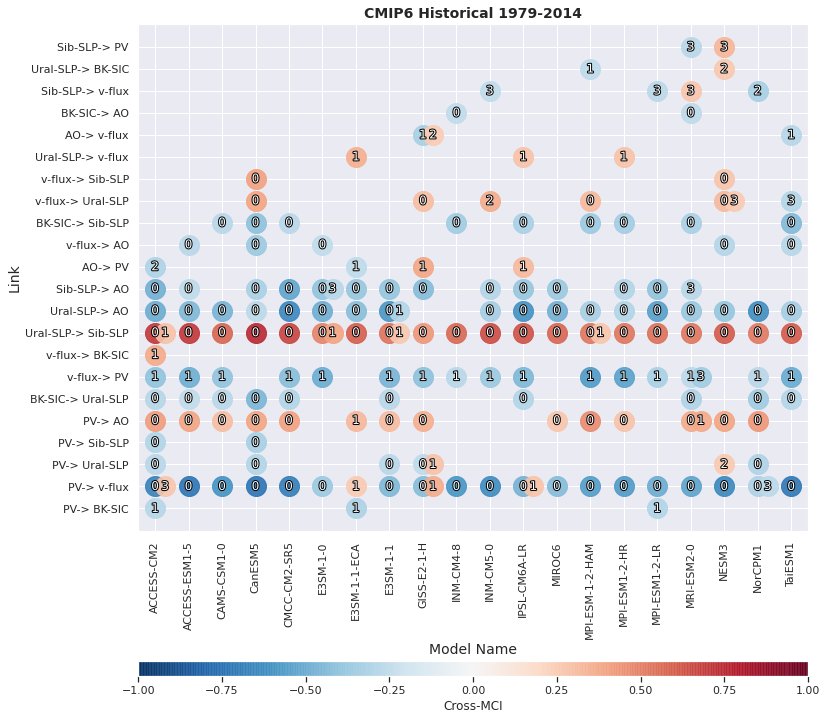

In [13]:
#########Settings for the plot###################################################
sns.set(style="darkgrid")  
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title("CMIP6 Historical 1979-2014", fontsize=14, fontweight='bold')
ax.set_xlim([-0.5, len(datalist)-0.5])
ax.set_xticks(np.linspace(0, len(datalist)-1, len(datalist)))
ax.set_xticklabels(datalist,fontsize=11, rotation=90)
ax.set_xlabel('Model Name',fontsize=14)
ax.set_ylabel('Link',fontsize=14)
mycmap = matplotlib.cm.get_cmap('RdBu_r')
mynorm = matplotlib.colors.Normalize(vmin=-1.0, vmax=1.0)

# Loop through all models
for nr_model, datasource in enumerate(datalist): 
     
    for idx, variable in enumerate (list (lll[nr_model].keys ())): 
        # if one connection has more than one link: 
        if len(list(lll[nr_model].values ())[idx]) > 1:
            for idn, tt in enumerate (list(lll[nr_model].values ())[idx]):
                # define a position "pos" of the nodes in the plot.
                pos = nr_model + np.linspace (0, 0.3, len (tt)) 
                pfc = plt.scatter(pos[idn], variable, c=tt[1], vmin=-1.0, vmax=1.0, marker="o", alpha=0.9, s = 400, cmap=mycmap)
                text = plt.text(pos[idn], variable, s=tt[0], color='white',  verticalalignment='center', horizontalalignment='center') 
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), 
                                       path_effects.Normal()])  
        # if one connection has exactly one link:
        else: 
            pfc = plt.scatter(datasource, variable, c=(list(lll[nr_model].values ())[idx][0][1]), vmin=-1.0, vmax=1.0, marker="o", alpha=0.9, s = 400, cmap=mycmap)
            text = plt.text(datasource, variable, s=(list(lll[nr_model].values ())[idx][0][0]), color='white',  verticalalignment='center', horizontalalignment='center') 
            text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])      

##################################################################################
#additional setting for the colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="3%", pad=1.8, pack_start=True)
fig.add_axes(cax)
fig.colorbar(pfc, cax=cax, orientation="horizontal", label = 'Cross-MCI')
##################################################################################
#plt.savefig ('/path_to_the_folder/filename.png', dpi = 120, bbox_inches = 'tight')

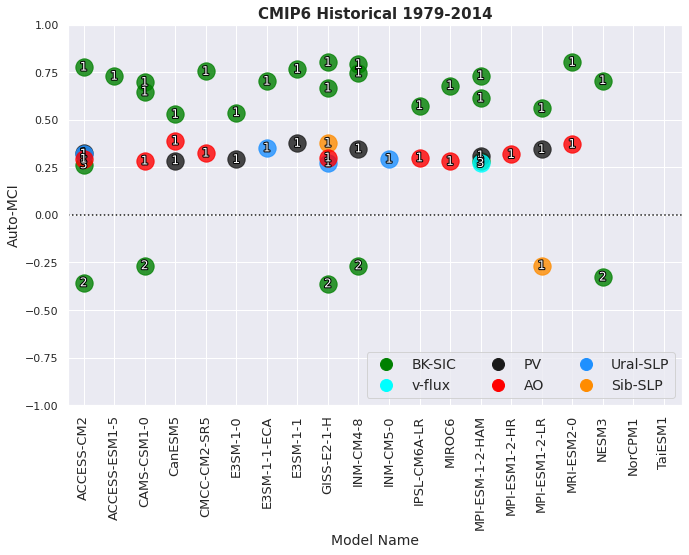

In [14]:
#########Settings for the plot###################################################
dict_link_color = dict([('BK-SIC', 'green') ,('v-flux', 'cyan'), ('PV', 'k'), ('AO', 'red'), 
                         ('Ural-SLP', 'dodgerblue'), ('Sib-SLP', 'darkorange')])
fig, ax = plt.subplots(figsize = (11,7))
ax.set_title("CMIP6 Historical 1979-2014", fontsize=15, fontweight='bold')
ax.set_xlim([-0.5, len(datalist)-0.4])
ax.set_xticks(np.linspace(0, len(datalist)-1, len(datalist)))
ax.set_xticklabels(datalist,fontsize=13, rotation=90)
ax.set_xlabel('Model Name',fontsize=14)
ax.set_ylim([-1.0, 1.0])
ax.set_ylabel('Auto-MCI',fontsize=14)



for nr_model, datasource in enumerate(datalist): 
    for idx, variable in enumerate (list (lll_auto[nr_model].keys ())): 
        if len(list(lll_auto[nr_model].values ())[idx]) > 1:
            for idn,tt in enumerate (list(lll_auto[nr_model].values ())[idx]):
                pos = nr_model + np.linspace (0, 0., len (list(lll_auto[nr_model].values ())[idx])) 
                plt.scatter (pos[idn], list(lll_auto[nr_model].values ())[idx][idn][1], c=dict_link_color [list (lll_auto[nr_model].keys ())[idx]], 
                             vmin=-1.0, vmax=1.0, marker="o", alpha=0.8, s = 300)
                text = plt.text(pos[idn], list(lll_auto[nr_model].values ())[idx][idn][1], s=str (list(lll_auto[nr_model].values ())[idx][idn][0]), color='white',  verticalalignment='center', horizontalalignment='center') 
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()]) 
        else: 
            plt.scatter(datasource, list(lll_auto[nr_model].values ())[idx][0][1], c=dict_link_color [list (lll_auto[nr_model].keys ())[idx]], vmin=-1.0, vmax=1.0, marker="o", alpha=0.8, s = 300)
            text = plt.text(datasource, list(lll_auto[nr_model].values ())[idx][0][1], s=str (list(lll_auto[nr_model].values ())[idx][0][0]), color='white',  verticalalignment='center', horizontalalignment='center') 
            text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])   

            
#Plot horizonral line at y=0
ax.axhline (y=0, color = 'k', linestyle = ':') 
#Playing with legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='', ) for color in dict_link_color.values()]
divider = make_axes_locatable(ax)
plt.legend(markers, dict_link_color.keys(), numpoints=1,  ncol = 3 ,markerscale=2, fontsize=14, loc = 4) #frameon=False,
#plt.savefig ('/path_to_the_folder/filename_AUTOCORRELATION.png', dpi = 120, bbox_inches = 'tight')